In [1]:
# The code was removed by Watson Studio for sharing.

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline 

import math

from project_lib import Project # from watson studio desktop to read data from projects

In [3]:
# next few lines are for cplex
import sys 
try:   
    import docplex.mp
    import cplex
except:
    if hasattr(sys, 'real_prefix'):
        #we are in a virtual env.
        !pip install docplex
        !pip install cplex
    else:
        !pip install --user docplex
        !pip install --user cplex

from docplex.mp.advmodel import AdvModel as Model        

# Read Stock Data

In [4]:
# The code was removed by Watson Studio for sharing.

,date,symbol,volume,open,close,high,low,adjclose
0,2019-04-18,A,2874100,75.730003,76.169998,76.540001,75.309998,76.169998
1,2019-04-17,A,4472000,78.150002,75.430000,78.320000,74.459999,75.430000
2,2019-04-16,A,3441500,80.820000,77.550003,80.959999,77.190002,77.550003
3,2019-04-15,A,1627300,81.000000,80.400002,81.129997,79.910004,80.400002
4,2019-04-12,A,1249300,81.430000,80.980003,82.059998,80.900002,80.980003


In [5]:
#stocks = pd.read_csv(project.get_file("history_60d.csv"))
st = stocks[['date','symbol','close','volume']]
list_stocks = ['IBM','APPL','AMZN','NFLX','NVDA','FB','GOOGL','MSFT']
st_r = st[st['symbol'].isin(list_stocks)]
# print prices from a few stocks
stocks_data = st_r.pivot(index='date', columns='symbol', values='close')
stocks_data.head()

symbol,AMZN,FB,GOOGL,IBM,MSFT,NFLX,NVDA
date,,,,,,,
2019-02-20,1622.099976,162.559998,1120.589966,138.000000,107.150002,359.910004,158.550003
2019-02-21,1619.439941,160.039993,1104.209961,137.839996,109.410004,356.970001,155.770004
2019-02-22,1631.560059,161.889999,1116.560059,139.250000,110.970001,363.019989,159.190002
2019-02-25,1633.000000,164.619995,1117.329956,139.460007,111.589996,363.910004,158.690002
2019-02-26,1636.400024,164.130005,1122.010010,139.720001,112.360001,364.970001,157.100006


## Get S&P 500 Tickers from wikipedia:

+ code: https://pythonprogramming.net/sp500-company-price-data-python-programming-for-finance/

In [6]:
import bs4 as bs
import pickle
import requests

def save_sp500_tickers():
    resp = requests.get('http://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
    soup = bs.BeautifulSoup(resp.text, 'lxml')
    table = soup.find('table', {'class': 'wikitable sortable'})
    tickers = []
    for row in table.findAll('tr')[1:]:
        ticker = row.findAll('td')[0].text[0:-1]
        tickers.append(ticker)

    with open("sp500tickers.pickle","wb") as f:
        pickle.dump(tickers,f)

    return tickers

sp500 = save_sp500_tickers()

# Get Data in the Right Shape for Optimization with CPLEX

+ drop duplicates 
+ pivot data to get a matrix of dates (rows) by stocks (columns) 


In [7]:
st = st.drop_duplicates(subset =['date','symbol'],keep = False)
prices = st.pivot(index='date', columns='symbol', values='close')

In [8]:
prices.head()

symbol,A,AA,AAAU,AABA,AAC,AADR,AAL,AAMC,AAME,AAN,...,ZSL,ZTO,ZTR,ZTS,ZUMZ,ZUO,ZVO,ZYME,ZYNE,ZYXI
date,,,,,,,,,,,,,,,,,,,,,
2019-02-20,78.559998,29.240000,13.38,69.400002,3.12,45.840000,35.060001,33.980000,2.63,53.709999,...,34.610001,19.230000,10.56,94.389999,25.790001,23.180000,NaN,15.06,4.90,5.22
2019-02-21,77.889999,29.580000,13.23,69.839996,2.94,45.630001,34.980000,35.000000,2.63,54.180000,...,35.770000,19.450001,10.51,93.470001,25.090000,23.309999,NaN,15.06,5.18,5.40
2019-02-22,78.419998,30.170000,13.28,71.720001,2.98,46.119999,35.490002,38.799999,2.85,54.970001,...,35.279999,19.610001,10.50,94.610001,25.000000,23.969999,NaN,14.94,5.12,5.43
2019-02-25,79.339996,30.780001,13.26,74.029999,3.09,46.439999,35.900002,39.000000,2.79,54.230000,...,35.450001,19.700001,10.55,94.389999,24.680000,24.240000,NaN,14.97,5.04,5.57
2019-02-26,78.550003,30.850000,13.28,74.250000,3.02,46.389999,36.250000,39.320000,2.80,55.000000,...,35.299999,19.490000,10.56,93.489998,24.480000,23.639999,NaN,15.21,5.25,5.40


+ stock prices are from February 20, 2019 to April 18, 2019
+ filter out stocks that are not in the S&P500 index
+ computing the 2-month returns as last_price / initial_price - 1

In [9]:
num_days = prices.shape[0]

print("1st. day in data: ", prices.index[0]) 
print("Last day in data: ", prices.index[num_days-1])

1st. day in data:  2019-02-20
Last day in data:  2019-04-18


In [10]:
results = []
list_stocks = []

for stock in sp500:
    try:
        if prices[stock].isna().count() == num_days: # only getting stocks without nulls
            initial_price = prices[stock][0]
            last_price = prices[stock][num_days-1]
            ret = (last_price / initial_price - 1)
            if math.isnan(ret):
                1
            else:
                results.append((stock,initial_price, last_price, ret))
                list_stocks.append(stock)
    except:
        print(stock, " not in data")

df_stocks = pd.DataFrame(results,columns=['stock','initial_price','last_price','ret'])    
df_stocks.index = df_stocks.stock
df_stocks = df_stocks[['initial_price','last_price','ret']]

print(df_stocks.shape)

AMCR  not in data
BKR  not in data
BRK.B  not in data
BF.B  not in data
CARR  not in data
CTVA  not in data
DD  not in data
GL  not in data
PEAK  not in data
HWM  not in data
J  not in data
LHX  not in data
NLOK  not in data
OTIS  not in data
RTX  not in data
TT  not in data
TFC  not in data
VIAC  not in data
(486, 3)


+ distribution of returns

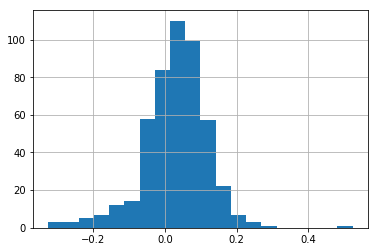

In [11]:
df_stocks.ret.hist(bins=20)

+ compute daily returns
+ compute covariance matrix of daily returns (multiple by number of observations to have an estimate of the 2-month volatility)

In [12]:
daily_returns = prices[df_stocks.index].pct_change(1)
daily_returns = daily_returns.iloc[1:] # deletes the first row that has no daily return
daily_returns = daily_returns.dropna(axis='columns') # filter out stocks with NaNs

In [13]:
daily_returns.columns

Index(['MMM', 'ABT', 'ABBV', 'ABMD', 'ACN', 'ATVI', 'ADBE', 'AMD', 'AAP',
       'AES',
       ...
       'WYNN', 'XEL', 'XRX', 'XLNX', 'XYL', 'YUM', 'ZBRA', 'ZBH', 'ZION',
       'ZTS'],
      dtype='object', name='symbol', length=486)

In [14]:
df_var = daily_returns[daily_returns.columns].cov() * daily_returns.shape[0]

# Decision Optimization with CPLEX (Community Edition)

+ define the quadratic programming model
+ create variables as the fraction to invest on each stock
+ define constraints 
    + sum of fractions need to be 1 (all the money will be invested)
    + target return is >= 9%
+ define objective function: minimize variance    
    

In [15]:
mdl = Model(name='stocks_portfolio')
df_stocks['frac'] = mdl.continuous_var_list(df_stocks.index, name='frac', ub=1)

In [16]:
# sum of fractions equal 100%
mdl.add_constraint(mdl.sum(df_stocks.frac) == 1);

# ensure minimal return on investment
target_return = .09
actual_return = mdl.dot(df_stocks.frac, df_stocks['ret'])
mdl.add_kpi(actual_return, 'ROI')
ct_return = mdl.add_constraint(actual_return >= target_return)

In [17]:
# KPIs
fracs = df_stocks.frac
variance = mdl.sum(float(df_var[s1][s2]) * fracs[s1] * fracs[s2] for s1 in df_stocks.index for s2 in df_stocks.index)
mdl.add_kpi(variance, 'Variance')

# finally the objective
mdl.minimize(variance)

In [18]:
assert mdl.solve(url=None, key=None), "Solve failed"
mdl.report()

* model stocks_portfolio solved with objective = 0.000
*  KPI: ROI      = 0.090
*  KPI: Variance = 0.000


In [19]:
fractions = []
all_fracs = {}
for row in df_stocks.itertuples():
    pct = 100 * row.frac.solution_value
    all_fracs[row[0]] = pct
    if pct>1e-3:
        print('-- fraction allocated in: {0:<12}: {1:.2f}%'.format(row[0], pct))
        fractions.append((row[0],pct))

-- fraction allocated in: BIIB        : 1.55%
-- fraction allocated in: CDNS        : 4.14%
-- fraction allocated in: CCL         : 0.21%
-- fraction allocated in: CMG         : 4.89%
-- fraction allocated in: CHD         : 6.89%
-- fraction allocated in: COST        : 0.62%
-- fraction allocated in: COTY        : 8.16%
-- fraction allocated in: DHR         : 4.87%
-- fraction allocated in: DISCA       : 1.40%
-- fraction allocated in: DLTR        : 1.83%
-- fraction allocated in: EVRG        : 5.80%
-- fraction allocated in: FB          : 2.84%
-- fraction allocated in: SJM         : 4.14%
-- fraction allocated in: LLY         : 7.08%
-- fraction allocated in: LKQ         : 0.41%
-- fraction allocated in: NVR         : 14.54%
-- fraction allocated in: PGR         : 1.50%
-- fraction allocated in: PSA         : 3.93%
-- fraction allocated in: QCOM        : 2.59%
-- fraction allocated in: SRE         : 7.40%
-- fraction allocated in: TWTR        : 3.87%
-- fraction allocated in: UAL    

In [20]:
fr = pd.DataFrame(fractions,columns=['stock','frac'])
fr.sort_values(by='frac',ascending=False).head()

,stock,frac
15,NVR,14.542040
6,COTY,8.164994
19,SRE,7.401238
13,LLY,7.079508
4,CHD,6.887451


In [21]:
fr.shape

(24, 2)